In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Определение директорий

In [2]:
test_mask_dir = "../data/laser_data/test/mask/"
test_img_dir = "../data/laser_data/test/img/"

test_dir = "../data/test/"
train_dir = "../data/laser_data/train/"

# Первый вариант генератора данных

## Генератор чтения масок

In [3]:
def MaskGenerator(directory, batch_size=1):
    i = 0
    files = sorted(os.listdir(directory))
    n_files = len(files)
    mask_batch = np.zeros([batch_size, 200, 2048, 1])
    while 1:
        for j in range(batch_size):
            
            mask = np.fromfile(os.path.join(directory,files[(i+j) % n_files]), dtype=np.ubyte)
            mask_batch[j, :, :, :] = mask.reshape([1, 200, 2048, 1])
            
        i += batch_size
        i = i % n_files
        
        yield mask_batch

## Совместный генератор чтения изображений и масок

Образцы данного генератора для тренировочных и валидационных данных с указанным размером батча подается на нейронную сеть при обучении.

In [4]:
def ImgMaskGenerator(directory, batch_size):

    mask_generator = MaskGenerator(directory=os.path.join(directory, 'mask'),
                                   batch_size=batch_size)
    
    img_datagen = ImageDataGenerator(rescale=1./255)
    
    img_generator = img_datagen.flow_from_directory(directory,
                                             class_mode=None,
                                             target_size=(200, 2048),
                                             batch_size=batch_size,
                                             shuffle=False,
                                             )
    
    train_generator = zip(img_generator, mask_generator)
    
    return train_generator

## Пример генератора

In [5]:
train_generator = ImgMaskGenerator(directory=train_dir,
                                   batch_size=1)

Found 24246 images belonging to 3 classes.


In [6]:
train_generator

## Проверка пары выходных данных генератора (изображение, маска)

Тип выходных данных генератора (д.б. tuple): <class 'tuple'>
(1, 200, 2048, 3)
(1, 200, 2048, 1)


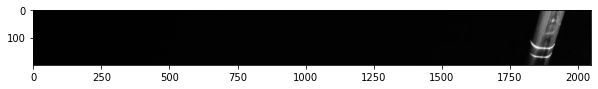

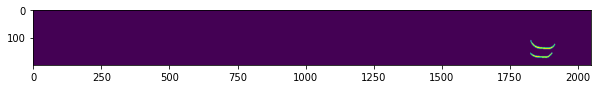

In [7]:
a = next(train_generator)

print('Тип выходных данных генератора (д.б. tuple):', type(a))
print(a[0].shape)
print(a[1].shape)

plt.figure(figsize=(10,10))
plt.imshow(a[0][0,:,:,:])

plt.figure(figsize=(10,10))
plt.imshow(a[1][0,:,:,:])

# Второй вариант генератора данных

## Формирование массивов с путями к файлам

In [8]:
train_img_dir = os.path.join(train_dir, 'img')
images = sorted(
    [
        os.path.join(train_img_dir, fname)
        for fname in os.listdir(train_img_dir)
    ]
)


train_mask_dir = os.path.join(train_dir, 'mask')
masks = sorted(
    [
        os.path.join(train_mask_dir, fname)
        for fname in os.listdir(train_mask_dir)
    ]
)

print("Number of samples:", len(images), len(masks))
for train_img_dir, train_mask_dir in zip(images[:10], masks[:10]):
    print(train_img_dir[-33:], "|", train_mask_dir[-34:])
    
print('Количество изображений:', len(images))

Number of samples: 24246 24246
210416D.003_1400701D.E003_0_0.jpg | 210416D.003_1400701D.E003_0_0.mask
210416D.003_1400701D.E003_0_1.jpg | 210416D.003_1400701D.E003_0_1.mask
6D.003_1400701D.E003_100000_1.jpg | 6D.003_1400701D.E003_100000_1.mask
6D.003_1400701D.E003_100005_1.jpg | 6D.003_1400701D.E003_100005_1.mask
16D.003_1400701D.E003_10000_1.jpg | 16D.003_1400701D.E003_10000_1.mask
6D.003_1400701D.E003_100010_1.jpg | 6D.003_1400701D.E003_100010_1.mask
6D.003_1400701D.E003_100015_1.jpg | 6D.003_1400701D.E003_100015_1.mask
6D.003_1400701D.E003_100020_1.jpg | 6D.003_1400701D.E003_100020_1.mask
6D.003_1400701D.E003_100025_1.jpg | 6D.003_1400701D.E003_100025_1.mask
6D.003_1400701D.E003_100030_1.jpg | 6D.003_1400701D.E003_100030_1.mask
Количество изображений: 24246


## Функция чтения изображения или маски, выходные данные - TF тензор

In [9]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 1024

def read_data(file_path, mask=False, height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    
    data = tf.io.read_file(file_path)
    
    if mask:
        
        data = tf.io.decode_raw(data, tf.int8)
        data = tf.reshape(data, [200, 2048,1])
        data = tf.image.resize(images=data, size=[height, width])
        
    else:
        
        data = tf.image.decode_png(data, channels=3)
        data.set_shape([None, None, 3])
        data = tf.image.resize(images=data, size=[height, width])
        data = data / 255.
        
    return data

## Совместный генератор чтения изображений и масок

In [10]:
def load_data(image_list, mask_list):
    image = read_data(image_list)
    mask  = read_data(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list, split='train', batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(8*batch_size) if split == 'train' else dataset 
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

## Пример генератора

In [11]:
train_datagen = data_generator(images, masks, batch_size=16)

In [12]:
print(train_datagen)

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 128, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 128, 1024, 1), dtype=tf.float32, name=None))>


## Проверка пары выходных данных генератора (изображение, маска)

Тип выходных данных генератора (д.б. tuple): <class 'tuple'>
(16, 128, 1024, 3)
(16, 128, 1024, 1)


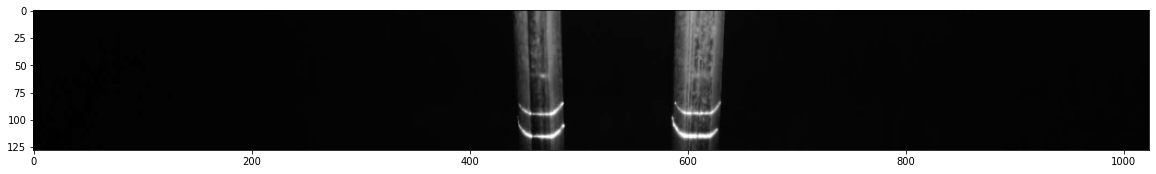

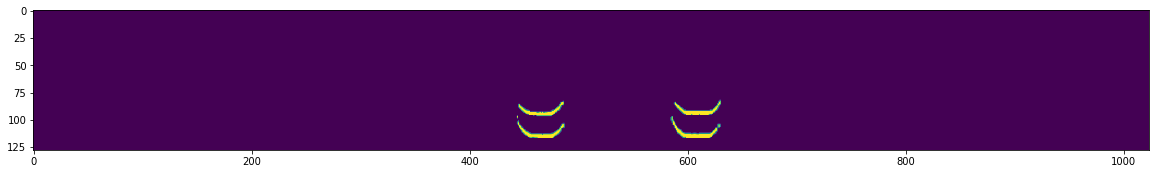

In [13]:
a = next(iter(train_datagen.take(1)))

print('Тип выходных данных генератора (д.б. tuple):', type(a))
print(a[0].shape)
print(a[1].shape)

plt.figure(figsize=(20,10))
plt.imshow(a[0][0,:,:,:])

plt.figure(figsize=(20,10))
plt.imshow(a[1][0,:,:,:])

In [14]:
asd

NameError: name 'asd' is not defined

# Нейронная сеть

In [ ]:
import matplotlib.pyplot as plt 

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
image, mask = next(iter(train_datagen.take(1))) # train_dataset
print(image.shape, mask.shape)

for (img, msk) in zip(image[:5], mask[:5]):
    print(mask.numpy().min(), mask.numpy().max())
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(), 
    )

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers

# https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(0.001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=1):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(20, 20))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
epochs = 6
model.fit(
    train_datagen,
    epochs=epochs, 
    callbacks=[DisplayCallback(train_datagen)]
)

In [ ]:
tf.keras.models.save_model(model, './model')

In [ ]:
test_image_path = './IMG_2433.JPG'

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 1024

def read_data(file_path, mask=False, height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    
    data = tf.io.read_file(file_path)
    
    if mask:
        
        data = tf.io.decode_raw(data, tf.int8)
        data = tf.reshape(data, [200, 2048,1])
        data = tf.image.resize(images=data, size=[height, width])
        
    else:
        
        data = tf.image.decode_png(data, channels=3)
        data.set_shape([None, None, 3])
        data = tf.image.resize(images=data, size=[height, width])
        data = data / 255.
        
    return data

def load_data(image_list):
    image = read_data(image_list)
    
    return image




# test_img

In [ ]:
%time
test_img = read_data(test_image_path)
test_img = tf.reshape(test_img, [1, 128, 1024, 3])

In [ ]:
%time
mask = model.predict(test_img)


In [ ]:
title = ['Input Image', 'Predicted Mask']

plt.figure(figsize=(20, 10))
plt.imshow(test_img[0])
plt.figure(figsize=(20, 10))
plt.imshow(mask[0])

In [ ]:
!jupyter kernelspec list